In [1]:
%load_ext autoreload
%autoreload 2 

In [6]:
# If on colab
!pip install latentshift

In [2]:
import io
import os,sys

import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import classifiers
import autoencoders
import taming
import video_utils

In [3]:
# This is needed until the library is merged into captum
# !pip uninstall captum -y 
!git clone https://github.com/ieee8023/captum

In [3]:
sys.path.insert(0,"captum")
import captum

In [5]:
ae = autoencoders.VQGAN(weights="faceshq", download=True)
model = classifiers.FaceAttribute(download=True)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


In [6]:
x = PIL.Image.open("latentshift/sample_images/101.jpg").convert('RGB') 
x = torchvision.transforms.ToTensor()(x)[None,...]

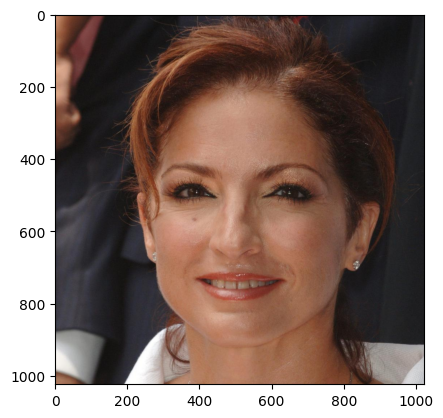

In [7]:
plt.imshow(x[0].permute(1, 2, 0).detach().numpy());

In [8]:
if torch.cuda.is_available():
    model = model.cuda()
    ae = ae.cuda()
    x = x.cuda()

In [9]:
model.targets

['blurry',
 'sideburns',
 'wearing_earrings',
 'bald',
 'goatee',
 'mustache',
 '5_o_clock_shadow',
 'arched_eyebrows',
 'no_beard',
 'heavy_makeup',
 'male',
 'wearing_lipstick',
 'black_hair',
 'high_cheekbones',
 'smiling',
 'mouth_slightly_open',
 'oval_face',
 'bushy_eyebrows',
 'attractive',
 'young',
 'gray_hair',
 'brown_hair',
 'blond_hair',
 'pale_skin',
 'chubby',
 'double_chin',
 'big_nose',
 'bags_under_eyes',
 'wearing_necklace',
 'wearing_necktie',
 'rosy_cheeks',
 'bangs',
 'wavy_hair',
 'straight_hair',
 'wearing_hat',
 'big_lips',
 'narrow_eyes',
 'pointy_nose',
 'receding_hairline',
 'eyeglasses']

In [10]:
target = model.targets.index("smiling")

Shift: 0, Pred: 0.9251329898834229, pixel_diff: 0.0, sum*diff_pct: 3019.021484375
Shift: -10.0, Pred: 0.8847969174385071, pixel_diff: 90.33834838867188, sum*diff_pct: 3019.021484375
Shift: -21.0, Pred: 0.8238259553909302, pixel_diff: 189.41098022460938, sum*diff_pct: 3019.021484375
Shift: -34.0, Pred: 0.7319025993347168, pixel_diff: 305.48651123046875, sum*diff_pct: 3019.021484375
Shift: -48.0, Pred: 0.5872170329093933, pixel_diff: 429.1630554199219, sum*diff_pct: 3019.021484375
Shift: -63.0, Pred: 0.4070163667201996, pixel_diff: 560.083251953125, sum*diff_pct: 3019.021484375
Shift: -80.0, Pred: 0.24203473329544067, pixel_diff: 705.2288208007812, sum*diff_pct: 3019.021484375
Shift: -98.0, Pred: 0.1479116827249527, pixel_diff: 853.5538940429688, sum*diff_pct: 3019.021484375
Shift: -118.0, Pred: 0.09649872779846191, pixel_diff: 1013.6220703125, sum*diff_pct: 3019.021484375
Selected bounds:  -118.0 0
Lambdas to compute:  [-118.         -104.88888889  -91.77777778  -78.66666667  -65.555555

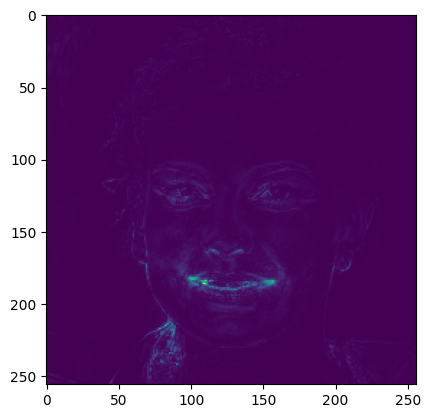

In [11]:
attr = captum.attr.LatentShift(model, ae)
output = attr.attribute(
    x, 
    target=target,
    return_dicts=True,
)[0]
plt.imshow(output['heatmap'].mean(0));

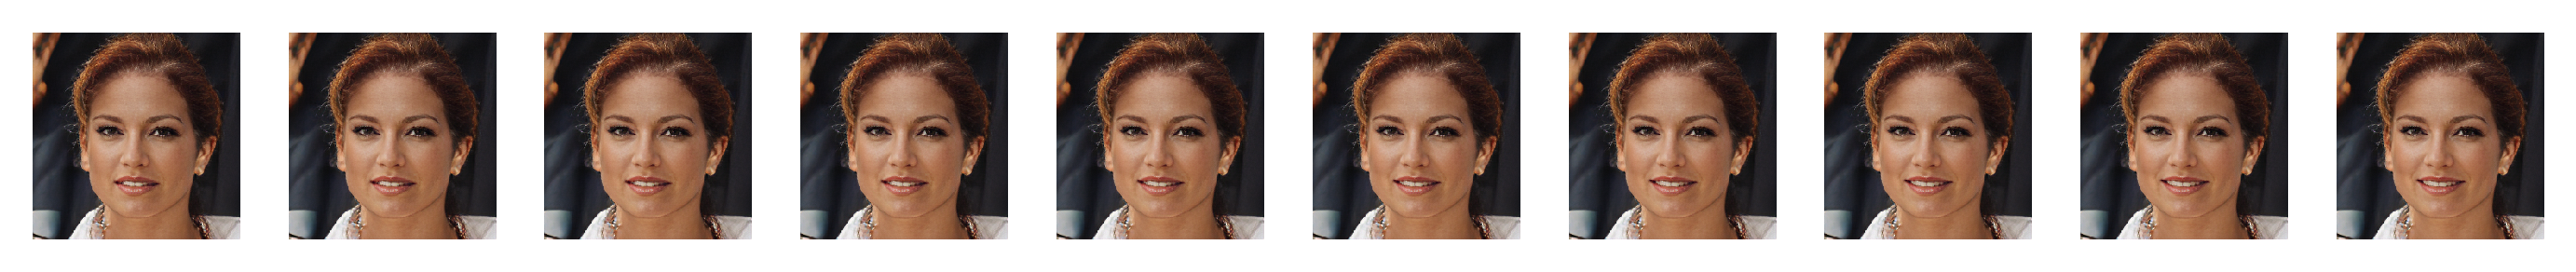

In [12]:
images_f = [h.transpose(1, 2, 0) for h in output["generated_images"]]
fig, axs = plt.subplots(ncols=len(images_f), squeeze=False, figsize=(8,3), dpi=350)
for i, img in enumerate(images_f):
    axs[0, i].imshow(img, interpolation='none')
    axs[0, i].axis('off');
plt.tight_layout()

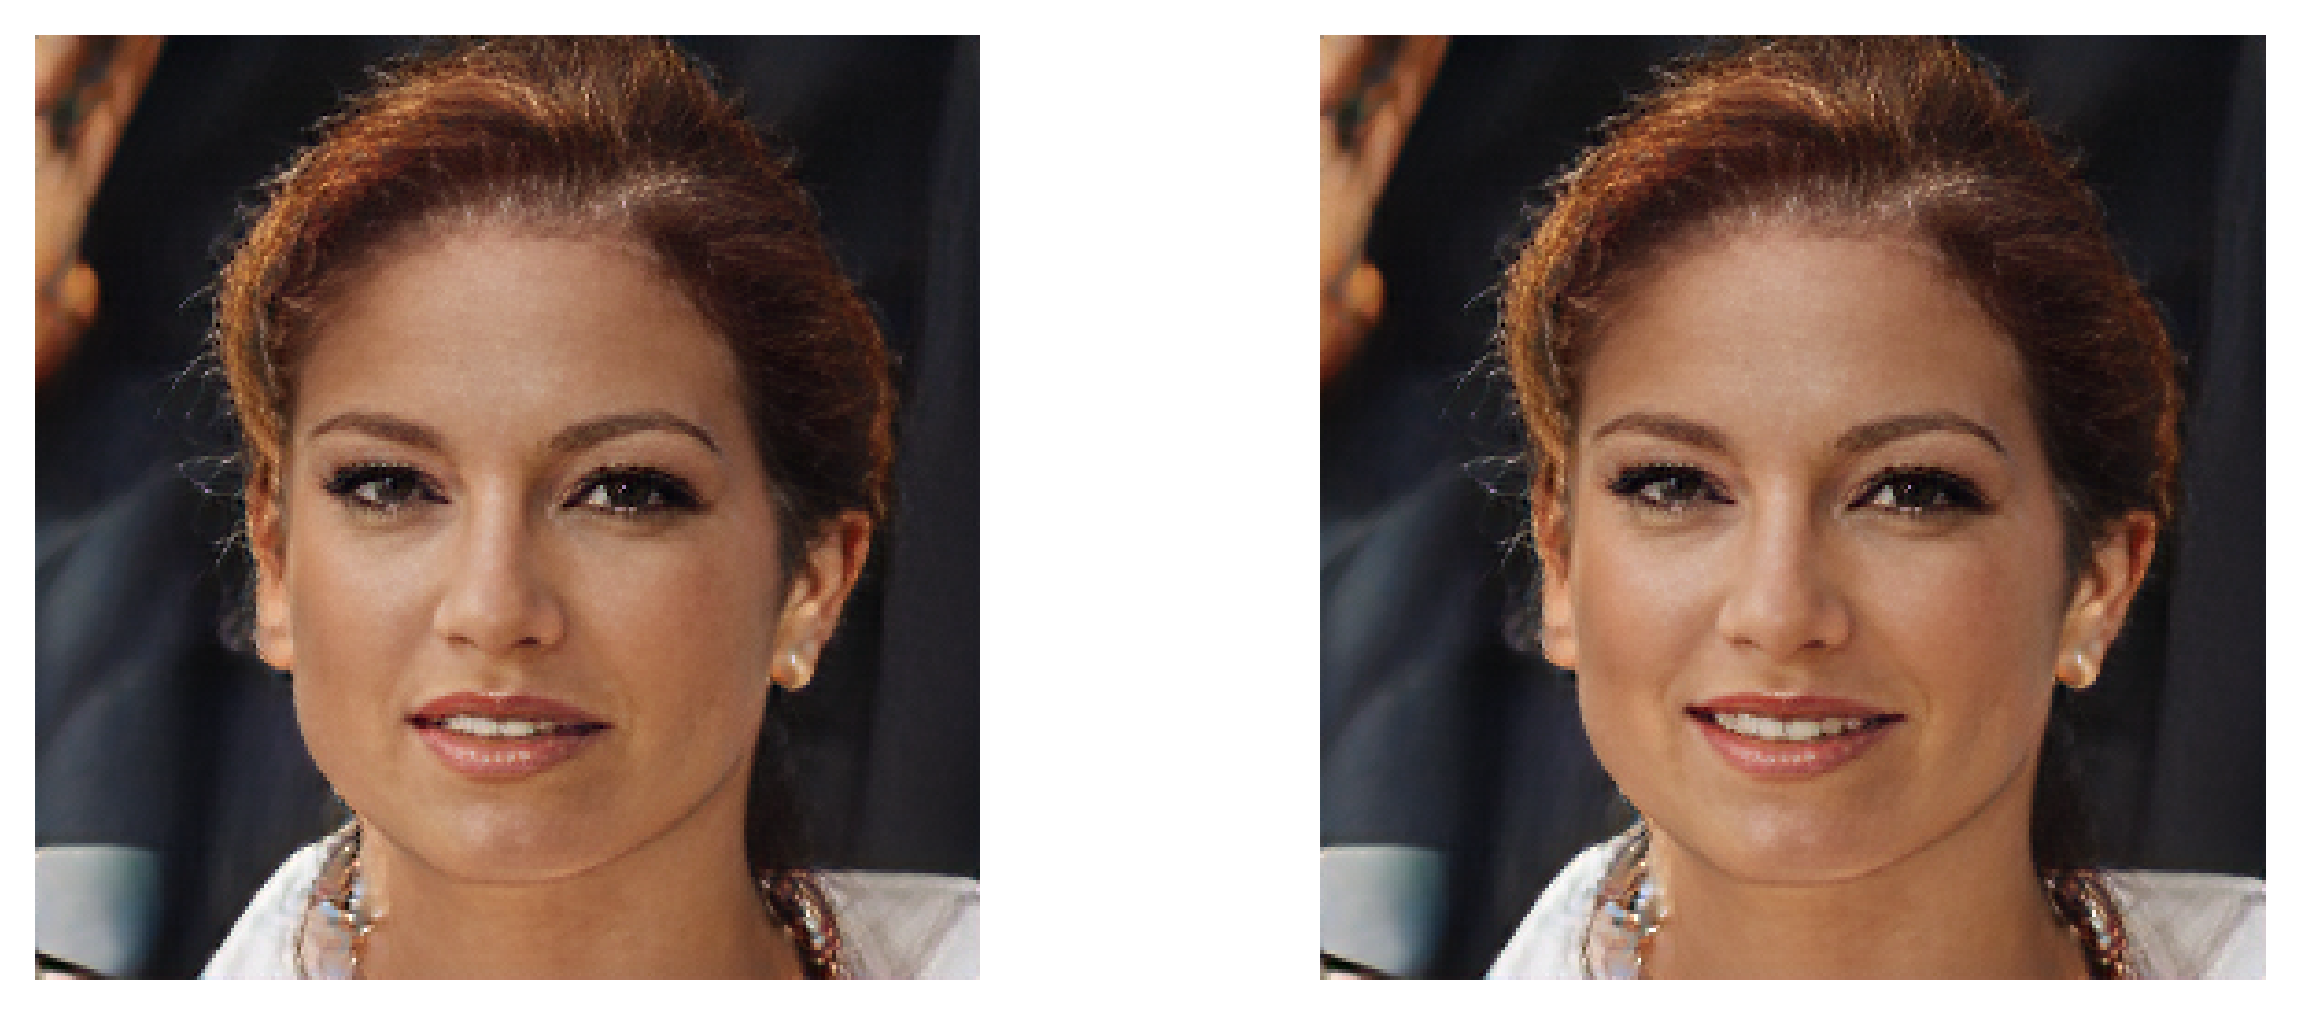

In [13]:
fig, axs = plt.subplots(ncols=2, squeeze=False, figsize=(8,3), dpi=350)
for i, img in enumerate([images_f[0], images_f[-1]]):
    axs[0, i].imshow(img, interpolation='none')
    axs[0, i].axis('off');
fig.tight_layout()

In [15]:
video_utils.generate_video(output, "test")

ffmpeg -loglevel quiet -stats -y -i /tmp/gifsplanation/image-%d.png -c:v libx264 -vf scale=-2:256 -profile:v baseline -level 3.0 -pix_fmt yuv420p 'test.mp4'
b''


frame=   20 fps=0.0 q=-1.0 Lsize=      16kB time=00:00:00.76 bitrate= 173.4kbits/s speed=10.7x    
